Import libraries

In [1]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import folium
from bs4 import BeautifulSoup

Transform the data

- Hong Kong is divided into 18 districts. I extracted the table from the latest census in 2016 from Wikipedia, which includes Population and Population Growth that will be useful for further analysis

In [2]:
# Extract the data from Wikipedia
table_name = 'wikitable sortable'
source = requests.get('https://en.wikipedia.org/wiki/Districts_of_Hong_Kong').text
soup=BeautifulSoup(source,'html.parser')
soup_table = soup.find('table', attrs={'class': table_name})
#Create Dataframe
df1 = pd.read_html(str(soup_table))[0]
df1

,District,Chinese,Population (2016)[11],Population Growth (From 2006)[11],Density(/km2)[11]
0,Central and Western,中西區,243266,-2.7%,19391
1,Eastern,東區,555034,-2.8%,30861
2,Southern,南區,274994,-0.6%,7080
3,Wan Chai,灣仔區,180123,-0.1%,17137
4,Hong Kong Island subtotal,Hong Kong Island subtotal,1253417,-1.2%,15691
5,Sham Shui Po,深水埗區,405869,+11.0%,43381
6,Kowloon City,九龍城區,418732,+15.5%,41802
7,Kwun Tong,觀塘區,648541,+10.4%,57530
8,Wong Tai Sin,黃大仙區,425235,+0.4%,45711
9,Yau Tsim Mong,油尖旺區,342970,+22.3%,49046


Some of the unnecessary rows (subtotal & Marine) are removed. The Chinese and Density(/km2) columns are also removed

In [3]:
#drop unncessary rows and columns
df1.drop([4,10,20,21], inplace=True)
df1.drop(['Chinese','Density(/km2)[11]'], axis=1, inplace = True)
df1.head()

,District,Population (2016)[11],Population Growth (From 2006)[11]
0,Central and Western,243266,-2.7%
1,Eastern,555034,-2.8%
2,Southern,274994,-0.6%
3,Wan Chai,180123,-0.1%
5,Sham Shui Po,405869,+11.0%


In [4]:
#rename columns
df1.rename(columns={'Population (2016)[11]':'Population', 'Population Growth (From 2006)[11]':'Population Growth', 'Density(/km2)[11]':'Density(/km2)' }, inplace=True)
df1.head()

,District,Population,Population Growth
0,Central and Western,243266,-2.7%
1,Eastern,555034,-2.8%
2,Southern,274994,-0.6%
3,Wan Chai,180123,-0.1%
5,Sham Shui Po,405869,+11.0%


In [5]:
# Add geo-spatial data (latitude and longitude)
df2 = pd.read_csv('hklatlon.csv')

In [6]:
# Merge two tables into a new dataframe
df = pd.merge(df1, df2, on='District')
df.head()

,District,Population,Population Growth,Latitude,Longitude,Region
0,Central and Western,243266,-2.7%,22.2833,114.15000,Hong Kong Island
1,Eastern,555034,-2.8%,22.28411,114.22414,Hong Kong Island
2,Southern,274994,-0.6%,22.24725,114.15880,Hong Kong Island
3,Wan Chai,180123,-0.1%,22.2799,114.17370,Hong Kong Island
4,Sham Shui Po,405869,+11.0%,22.3318,114.16210,Kowloon


Create a map of Hong Kong with districts superimposed on top

In [7]:
address = 'Hong Kong'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

22.2793278 114.1628131


In [8]:
map_hk = folium.Map(location=[latitude, longitude],zoom_start=10)

for lat,lng,district,region in zip(df['Latitude'],df['Longitude'],df['District'],df['Region']):
    label = '{}, {}'.format(district,region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_hk)
    
map_hk

Let's explore the first district in our dataframe

In [9]:
# Get the district's name on the first row of our dataframe
df.loc[0, 'District']

'Central and Western'

In [10]:
district_latitude = df.loc[0, 'Latitude'] # district latitude value
district_longitude = df.loc[0, 'Longitude'] # district longitude value

district_name = df.loc[0, 'District'] # district name

print('Latitude and longitude values of {} are {}, {}.'.format(district_name, 
                                                               district_latitude, 
                                                               district_longitude))

Latitude and longitude values of Central and Western are 22.2833, 114.15.


Get the top 100 venues that are in Central and Western District within a radius of 500 meters

In [12]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    district_latitude, 
    district_longitude, 
    radius, 
    LIMIT)

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6039cfdb7a51cf4a2c7a6c4c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Central District',
  'headerFullLocation': 'Central District, Hong Kong',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 73,
  'suggestedBounds': {'ne': {'lat': 22.287800004500006,
    'lng': 114.15485410573811},
   'sw': {'lat': 22.278799995499995, 'lng': 114.1451458942619}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51f788118bbdc0a9b76d5189',
       'name': 'PMQ (元創方)',
       'location': {'address': '35 Aberdeen St',
        'crossStreet': 'at Hollywood Rd',
        'lat': 22.283297722569138,
        'lng': 114.15197106491307,
        'labeledL

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a pandas dataframe

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,PMQ (元創方),Arts & Crafts Store,22.283298,114.151971
1,The Old Man,Bar,22.282770,114.151774
2,Craftissimo,Beer Store,22.284589,114.148293
3,Teakha (茶·家),Tea Room,22.284506,114.148407
4,Blue Supreme,Bar,22.285148,114.149385


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

73 venues were returned by Foursquare.


Let's explore and cluster the districts in Hong Kong

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response'].get('groups',[{}])[0].get('items', [])
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
hk_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude'])

Central and Western
Eastern
Southern
Wan Chai
Sham Shui Po
Kowloon City
Kwun Tong
Wong Tai Sin
Yau Tsim Mong
Islands
Kwai Tsing
North
Sai Kung
Sha Tin
Tai Po
Tsuen Wan
Tuen Mun
Yuen Long


In [20]:
#size of the resulting dataframe
print(hk_venues.shape)
hk_venues.head()

(546, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central and Western,22.2833,114.15,PMQ (元創方),22.283298,114.151971,Arts & Crafts Store
1,Central and Western,22.2833,114.15,The Old Man,22.282770,114.151774,Bar
2,Central and Western,22.2833,114.15,Craftissimo,22.284589,114.148293,Beer Store
3,Central and Western,22.2833,114.15,Teakha (茶·家),22.284506,114.148407,Tea Room
4,Central and Western,22.2833,114.15,Blue Supreme,22.285148,114.149385,Bar


In [21]:
#check how many venues were returned for each district
hk_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Central and Western,73,73,73,73,73,73
Eastern,13,13,13,13,13,13
Kowloon City,70,70,70,70,70,70
Kwai Tsing,8,8,8,8,8,8
Kwun Tong,51,51,51,51,51,51
North,4,4,4,4,4,4
Sai Kung,57,57,57,57,57,57
Sha Tin,7,7,7,7,7,7
Sham Shui Po,59,59,59,59,59,59


In [22]:
# find out how many unique categories can be curated from all the returned venues

print('There are {} uniques categories.'.format(len(hk_venues['Venue Category'].unique())))

There are 128 uniques categories.


In [23]:
# one hot encoding
hk_onehot = pd.get_dummies(hk_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hk_onehot['District'] = hk_venues['District'] 

# move district column to the first column
fixed_columns = [hk_onehot.columns[-1]] + list(hk_onehot.columns[:-1])
hk_onehot = hk_onehot[fixed_columns]

hk_onehot.head()

,District,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Zoo
0,Central and Western,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Central and Western,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Central and Western,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Central and Western,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Central and Western,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [24]:
hk_onehot.shape

(546, 129)

In [25]:
hk_grouped = hk_onehot.groupby('District').mean().reset_index()
hk_grouped

,District,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Tapas Restaurant,Tea Room,Temple,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Zoo
0,Central and Western,0.000000,0.013699,0.013699,0.000000,0.000000,0.000000,0.000000,0.013699,0.041096,...,0.027397,0.013699,0.000000,0.027397,0.000000,0.000000,0.027397,0.041096,0.013699,0.0
1,Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,Kowloon City,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,...,0.000000,0.000000,0.000000,0.185714,0.000000,0.000000,0.014286,0.000000,0.000000,0.0
3,Kwai Tsing,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,Kwun Tong,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.019608,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,Sai Kung,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,...,0.017544,0.000000,0.000000,0.070175,0.000000,0.000000,0.017544,0.000000,0.017544,0.0
7,Sha Tin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.0
8,Sham Shui Po,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016949,0.000000,0.000000,0.016949,0.000000,0.000000,0.0
9,Southern,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [26]:
hk_grouped.shape

(16, 129)

Print each district along with the top 5 most common venues

In [308]:
num_top_venues = 5

for hood in hk_grouped['District']:
    print("----"+hood+"----")
    temp = hk_grouped[hk_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Central and Western----
                 venue  freq
0          Coffee Shop  0.11
1  Japanese Restaurant  0.11
2                 Café  0.08
3   Italian Restaurant  0.07
4             Wine Bar  0.04


----Eastern----
                venue  freq
0                Park  0.15
1  Chinese Restaurant  0.15
2        Dessert Shop  0.08
3   French Restaurant  0.08
4   Indian Restaurant  0.08


----Islands----
                             venue  freq
0          State / Provincial Park   0.5
1                      Picnic Area   0.5
2  Molecular Gastronomy Restaurant   0.0
3                             Pool   0.0
4                            Plaza   0.0


----Kowloon City----
                venue  freq
0     Thai Restaurant  0.19
1        Dessert Shop  0.14
2  Chinese Restaurant  0.09
3                Café  0.06
4         Coffee Shop  0.06


----Kwai Tsing----
                  venue  freq
0  Gym / Fitness Center  0.12
1  Hong Kong Restaurant  0.12
2           Gas Station  0.12
3               

Gather the result and put that into a pandas dataframe

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [28]:
#Display the top 10 venues for each district
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['District'] = hk_grouped['District']

for ind in np.arange(hk_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hk_grouped.iloc[ind, :], num_top_venues)

districts_venues_sorted.head(18)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,Japanese Restaurant,Coffee Shop,Café,Italian Restaurant,Wine Bar,Bar,Cocktail Bar,Vietnamese Restaurant,Restaurant,French Restaurant
1,Eastern,Chinese Restaurant,Park,Restaurant,Cantonese Restaurant,Japanese Restaurant,Hainan Restaurant,Indian Restaurant,Dessert Shop,Harbor / Marina,Hong Kong Restaurant
2,Kowloon City,Thai Restaurant,Dessert Shop,Chinese Restaurant,Café,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Cha Chaan Teng,Hotpot Restaurant,Noodle House
3,Kwai Tsing,Hong Kong Restaurant,Athletics & Sports,Gas Station,Grocery Store,Gym / Fitness Center,Park,Cantonese Restaurant,Chinese Restaurant,Farm,Fast Food Restaurant
4,Kwun Tong,Sushi Restaurant,Dessert Shop,Chinese Restaurant,Fast Food Restaurant,Cha Chaan Teng,Shopping Mall,Coffee Shop,Café,Cantonese Restaurant,Shanghai Restaurant
5,North,Pool,Playground,Cha Chaan Teng,Farm,Fast Food Restaurant,French Restaurant,Food Court,Flower Shop,Flea Market,Fish & Chips Shop
6,Sai Kung,Seafood Restaurant,Café,Coffee Shop,Thai Restaurant,Chinese Restaurant,Pizza Place,Dessert Shop,Pub,Pier,Burger Joint
7,Sha Tin,Campground,Vegetarian / Vegan Restaurant,Temple,Resort,Breakfast Spot,Café,Cantonese Restaurant,Zoo,Food Court,Flower Shop
8,Sham Shui Po,Noodle House,Chinese Restaurant,Dessert Shop,Shopping Mall,Fast Food Restaurant,Hobby Shop,Snack Place,Cha Chaan Teng,Italian Restaurant,Dumpling Restaurant
9,Southern,Sushi Restaurant,Cha Chaan Teng,Fast Food Restaurant,Japanese Restaurant,Park,Coffee Shop,Noodle House,Market,Bus Station,Shopping Mall


#### Cluster districts
- Run k-means to cluster the districts into 3 clusters

In [29]:
# set number of clusters
kclusters = 3

hk_grouped_clustering = hk_grouped.drop('District', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 1, 0, 1, 2, 1, 1, 1, 1])

Create a new dataframe that includes the cluster as well as the top 10 venues for each district

In [32]:
# add clustering labels
districts_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

hk_merged = df

# merge hk_grouped with hk_data to add latitude/longitude for each neighborhood
hk_merged = hk_merged.join(districts_venues_sorted.set_index('District'), on='District')
hk_merged.dropna(axis=0, inplace=True)
hk_merged.head() # check the last columns!

,District,Population,Population Growth,Latitude,Longitude,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,243266,-2.7%,22.2833,114.15000,Hong Kong Island,1.0,Japanese Restaurant,Coffee Shop,Café,Italian Restaurant,Wine Bar,Bar,Cocktail Bar,Vietnamese Restaurant,Restaurant,French Restaurant
1,Eastern,555034,-2.8%,22.28411,114.22414,Hong Kong Island,0.0,Chinese Restaurant,Park,Restaurant,Cantonese Restaurant,Japanese Restaurant,Hainan Restaurant,Indian Restaurant,Dessert Shop,Harbor / Marina,Hong Kong Restaurant
2,Southern,274994,-0.6%,22.24725,114.15880,Hong Kong Island,1.0,Sushi Restaurant,Cha Chaan Teng,Fast Food Restaurant,Japanese Restaurant,Park,Coffee Shop,Noodle House,Market,Bus Station,Shopping Mall
3,Wan Chai,180123,-0.1%,22.2799,114.17370,Hong Kong Island,1.0,Hotel,Italian Restaurant,Cantonese Restaurant,Japanese Restaurant,Hong Kong Restaurant,Chinese Restaurant,Coffee Shop,Lounge,Cha Chaan Teng,Korean Restaurant
4,Sham Shui Po,405869,+11.0%,22.3318,114.16210,Kowloon,1.0,Noodle House,Chinese Restaurant,Dessert Shop,Shopping Mall,Fast Food Restaurant,Hobby Shop,Snack Place,Cha Chaan Teng,Italian Restaurant,Dumpling Restaurant


In [33]:
hk_merged['Cluster Labels'] = hk_merged['Cluster Labels'].astype(int)

Visualize the resulting clusters

In [34]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hk_merged['Latitude'], hk_merged['Longitude'], hk_merged['District'], hk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As seen from the above diagram, most of the districts are in cluster 1, let's explore the top 10 common venues in cluster 1

In [38]:
hk_merged.loc[hk_merged['Cluster Labels'] == 1, hk_merged.columns[[0] + list(range(5, hk_merged.shape[1]))]]

,District,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Central and Western,Hong Kong Island,1,Japanese Restaurant,Coffee Shop,Café,Italian Restaurant,Wine Bar,Bar,Cocktail Bar,Vietnamese Restaurant,Restaurant,French Restaurant
2,Southern,Hong Kong Island,1,Sushi Restaurant,Cha Chaan Teng,Fast Food Restaurant,Japanese Restaurant,Park,Coffee Shop,Noodle House,Market,Bus Station,Shopping Mall
3,Wan Chai,Hong Kong Island,1,Hotel,Italian Restaurant,Cantonese Restaurant,Japanese Restaurant,Hong Kong Restaurant,Chinese Restaurant,Coffee Shop,Lounge,Cha Chaan Teng,Korean Restaurant
4,Sham Shui Po,Kowloon,1,Noodle House,Chinese Restaurant,Dessert Shop,Shopping Mall,Fast Food Restaurant,Hobby Shop,Snack Place,Cha Chaan Teng,Italian Restaurant,Dumpling Restaurant
5,Kowloon City,Kowloon,1,Thai Restaurant,Dessert Shop,Chinese Restaurant,Café,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Cha Chaan Teng,Hotpot Restaurant,Noodle House
6,Kwun Tong,Kowloon,1,Sushi Restaurant,Dessert Shop,Chinese Restaurant,Fast Food Restaurant,Cha Chaan Teng,Shopping Mall,Coffee Shop,Café,Cantonese Restaurant,Shanghai Restaurant
7,Wong Tai Sin,Kowloon,1,Coffee Shop,Park,Fast Food Restaurant,Pool,Szechuan Restaurant,Burger Joint,Bus Stop,Japanese Restaurant,Cha Chaan Teng,Temple
8,Yau Tsim Mong,Kowloon,1,Cha Chaan Teng,Chinese Restaurant,Coffee Shop,Noodle House,Sporting Goods Shop,Dessert Shop,Beer Bar,Market,Bakery,Steakhouse
12,Sai Kung,New Territories,1,Seafood Restaurant,Café,Coffee Shop,Thai Restaurant,Chinese Restaurant,Pizza Place,Dessert Shop,Pub,Pier,Burger Joint
13,Sha Tin,New Territories,1,Campground,Vegetarian / Vegan Restaurant,Temple,Resort,Breakfast Spot,Café,Cantonese Restaurant,Zoo,Food Court,Flower Shop


No wonder Hong Kong is a food paradise! Most of the common venues are restaurants, coffee shops and bars. As we are planning to open an organic bubble tea shop which will priced slightly higher than usual, let's explore the median monthly household income of the 18 districts before concluding the ideal district selection!

In [39]:
df3 = pd.read_csv('HK_median income.csv', index_col=0)
df3.head()

,Region,Median monthly household income
District,,
Central and Western,Hong Kong Island,41400
Wan Chai,Hong Kong Island,44100
Eastern,Hong Kong Island,34300
Southern,Hong Kong Island,32800
Yau Tsim Mong,Kowloon,30000


In [40]:
#sort the values in ascending order
df3.sort_values(by='Median monthly household income', ascending=True, inplace=True)

df_income = df3['Median monthly household income']
df_income

District
Kwun Tong              22500
Kowloon City           22500
Sham Shui Po           24300
Kwai Tsing             24700
Tuen Mun               25000
Wong Tai Sin           25500
Tai Po                 25800
Yuen Long              27000
Islands                28400
Sha Tin                29700
Yau Tsim Mong          30000
North                  30400
Tsuen Wan              32600
Southern               32800
Eastern                34300
Sai Kung               36500
Central and Western    41400
Wan Chai               44100
Name: Median monthly household income, dtype: int64

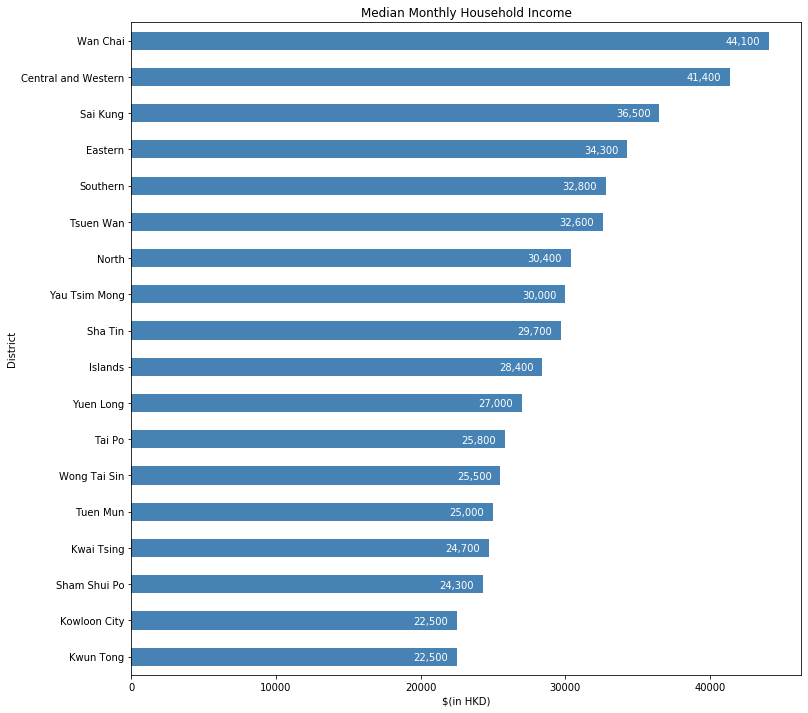

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_income.plot(kind='barh', figsize=(12,12), color='steelblue') #rotate the x-ticks by 90 degrees

plt.title('Median Monthly Household Income')
plt.ylabel('District')
plt.xlabel('$(in HKD)')
plt.yticks(rotation=0)
#plt.xticks(rotation=90)

#annotate arrow
for index, value in enumerate(df_income):
    label = format(int(value), ',')
    
#annotate text
    plt.annotate(label, xy=(value - 3000, index - 0.10), color='white')

from the chart, we can divide the 18 districts into 4 groups (based on the median monthly household income): High, Upper Medium, Lower Medium and Low Levels 

In [42]:
level = []
for i in range(0,len(df3)):
    if (df3['Median monthly household income'][i] > 33000):
        level.append("High Level Income")
    elif (df3['Median monthly household income'][i] >= 29500 and df3['Median monthly household income'][i] < 33000):
        level.append("Upper Medium Level Income")
    elif (df3['Median monthly household income'][i] >= 26000 and df3['Median monthly household income'][i] < 29500):
        level.append("Lower Medium Level Income")
    else:
        level.append("Low Level Income")   


df3['Level Labels'] = level
df3.head()

,Region,Median monthly household income,Level Labels
District,,,
Kwun Tong,Kowloon,22500,Low Level Income
Kowloon City,Kowloon,22500,Low Level Income
Sham Shui Po,Kowloon,24300,Low Level Income
Kwai Tsing,New Territories,24700,Low Level Income
Tuen Mun,New Territories,25000,Low Level Income


Before continuing, let's explore the population by age group in the 18 districts as well! Our target customers will highly aged between 15-44, let's grab the population of citizens aged between 15-44.

In [45]:
df4 = pd.read_csv('HK_age.csv')
df4["15-24"] = df4["15-24"].astype(str).astype(float)
df4.head()

,District,0-14,15-24,25-44,45-64,65+,Median age
0,Central and Western,0.11,0.10,0.31,0.31,0.18,43
1,Wan Chai,0.10,0.08,0.32,0.32,0.17,44
2,Eastern,0.12,0.09,0.30,0.32,0.00,44
3,Southern,0.12,0.09,0.30,0.32,0.17,44
4,Yau Tsim Mong,0.12,0.10,0.31,0.32,0.16,43


In [46]:
# merge the two tables and multify the age group % with the population
df5 = pd.merge(df,df4,on='District')
df5['Population of citizens aged 15-44'] =  (df5['15-24'] + df5['25-44']) * df5['Population']
df5.head()

,District,Population,Population Growth,Latitude,Longitude,Region,0-14,15-24,25-44,45-64,65+,Median age,Population of citizens aged 15-44
0,Central and Western,243266,-2.7%,22.2833,114.15000,Hong Kong Island,0.11,0.10,0.31,0.31,0.18,43,99739.06
1,Eastern,555034,-2.8%,22.28411,114.22414,Hong Kong Island,0.12,0.09,0.30,0.32,0.00,44,216463.26
2,Southern,274994,-0.6%,22.24725,114.15880,Hong Kong Island,0.12,0.09,0.30,0.32,0.17,44,107247.66
3,Wan Chai,180123,-0.1%,22.2799,114.17370,Hong Kong Island,0.10,0.08,0.32,0.32,0.17,44,72049.20
4,Sham Shui Po,405869,+11.0%,22.3318,114.16210,Kowloon,0.13,0.09,0.30,0.32,0.17,43,158288.91


In [52]:
df6 = pd.merge(df3,df5, on=['District','Region'])
df6.sort_values(by='Population of citizens aged 15-44', ascending=False, inplace=True)
df6

,District,Region,Median monthly household income,Level Labels,Population,Population Growth,Latitude,Longitude,0-14,15-24,25-44,45-64,65+,Median age,Population of citizens aged 15-44
7,Yuen Long,New Territories,27000,Lower Medium Level Income,607200,+15.0%,22.4400,114.02210,0.12,0.10,0.32,0.31,0.16,42,255024.00
9,Sha Tin,New Territories,29700,Upper Medium Level Income,659794,+8.6%,22.3833,114.18330,0.12,0.10,0.28,0.33,0.17,45,250721.72
0,Kwun Tong,Kowloon,22500,Low Level Income,648541,+10.4%,22.3233,114.21540,0.12,0.09,0.29,0.32,0.18,44,246445.58
14,Eastern,Hong Kong Island,34300,High Level Income,555034,-2.8%,22.28411,114.22414,0.12,0.09,0.30,0.32,0.00,44,216463.26
3,Kwai Tsing,New Territories,24700,Low Level Income,520572,-0.5%,22.3529,114.10000,0.11,0.10,0.29,0.32,0.18,44,203023.08
4,Tuen Mun,New Territories,25000,Low Level Income,489299,-2.5%,22.3916,113.97090,0.12,0.10,0.29,0.33,0.17,44,190826.61
15,Sai Kung,New Territories,36500,High Level Income,461864,+13.6%,22.3814,114.27330,0.12,0.09,0.31,0.32,0.16,43,184745.60
1,Kowloon City,Kowloon,22500,Low Level Income,418732,+15.5%,22.3287,114.19120,0.12,0.09,0.31,0.32,0.17,43,167492.80
5,Wong Tai Sin,Kowloon,25500,Low Level Income,425235,+0.4%,22.343,114.19300,0.11,0.10,0.28,0.33,0.19,45,161589.30
2,Sham Shui Po,Kowloon,24300,Low Level Income,405869,+11.0%,22.3318,114.16210,0.13,0.09,0.30,0.32,0.17,43,158288.91


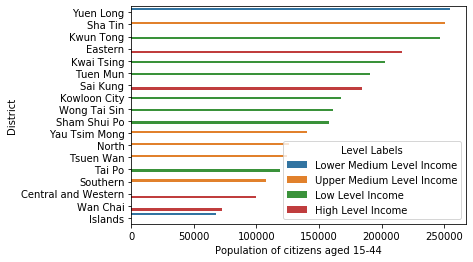

In [70]:
ax = sns.barplot(y='District', x='Population of citizens aged 15-44',hue='Level Labels',data=df6)
ax

Sha Tin District and Eastern District are seemingly the ideal locations for our bubble tea shop, as there is a large population base and their median monthly income belong to upper medium level or above

In [71]:
# Merge the common venues with the level labels table
df_new = pd.merge(df, districts_venues_sorted, on='District')
df_new1 = pd.merge(df_new,df3, on=['District','Region'])
df_new1

,District,Population,Population Growth,Latitude,Longitude,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Median monthly household income,Level Labels
0,Central and Western,243266,-2.7%,22.2833,114.15000,Hong Kong Island,1,Japanese Restaurant,Coffee Shop,Café,Italian Restaurant,Wine Bar,Bar,Cocktail Bar,Vietnamese Restaurant,Restaurant,French Restaurant,41400,High Level Income
1,Eastern,555034,-2.8%,22.28411,114.22414,Hong Kong Island,0,Chinese Restaurant,Park,Restaurant,Cantonese Restaurant,Japanese Restaurant,Hainan Restaurant,Indian Restaurant,Dessert Shop,Harbor / Marina,Hong Kong Restaurant,34300,High Level Income
2,Southern,274994,-0.6%,22.24725,114.15880,Hong Kong Island,1,Sushi Restaurant,Cha Chaan Teng,Fast Food Restaurant,Japanese Restaurant,Park,Coffee Shop,Noodle House,Market,Bus Station,Shopping Mall,32800,Upper Medium Level Income
3,Wan Chai,180123,-0.1%,22.2799,114.17370,Hong Kong Island,1,Hotel,Italian Restaurant,Cantonese Restaurant,Japanese Restaurant,Hong Kong Restaurant,Chinese Restaurant,Coffee Shop,Lounge,Cha Chaan Teng,Korean Restaurant,44100,High Level Income
4,Sham Shui Po,405869,+11.0%,22.3318,114.16210,Kowloon,1,Noodle House,Chinese Restaurant,Dessert Shop,Shopping Mall,Fast Food Restaurant,Hobby Shop,Snack Place,Cha Chaan Teng,Italian Restaurant,Dumpling Restaurant,24300,Low Level Income
5,Kowloon City,418732,+15.5%,22.3287,114.19120,Kowloon,1,Thai Restaurant,Dessert Shop,Chinese Restaurant,Café,Coffee Shop,Asian Restaurant,Fast Food Restaurant,Cha Chaan Teng,Hotpot Restaurant,Noodle House,22500,Low Level Income
6,Kwun Tong,648541,+10.4%,22.3233,114.21540,Kowloon,1,Sushi Restaurant,Dessert Shop,Chinese Restaurant,Fast Food Restaurant,Cha Chaan Teng,Shopping Mall,Coffee Shop,Café,Cantonese Restaurant,Shanghai Restaurant,22500,Low Level Income
7,Wong Tai Sin,425235,+0.4%,22.343,114.19300,Kowloon,1,Coffee Shop,Park,Fast Food Restaurant,Pool,Szechuan Restaurant,Burger Joint,Bus Stop,Japanese Restaurant,Cha Chaan Teng,Temple,25500,Low Level Income
8,Yau Tsim Mong,342970,+22.3%,22.3211,114.17260,Kowloon,1,Cha Chaan Teng,Chinese Restaurant,Coffee Shop,Noodle House,Sporting Goods Shop,Dessert Shop,Beer Bar,Market,Bakery,Steakhouse,30000,Upper Medium Level Income
9,Kwai Tsing,520572,-0.5%,22.3529,114.10000,New Territories,0,Hong Kong Restaurant,Athletics & Sports,Gas Station,Grocery Store,Gym / Fitness Center,Park,Cantonese Restaurant,Chinese Restaurant,Farm,Fast Food Restaurant,24700,Low Level Income


In [95]:
# Display only Eastern and Sha Tin Districts for comparison
df_new2 = df_new1.loc[(df_new1['District'] == 'Eastern') | (df_new1['District'] == 'Sha Tin')]
df_new2

,District,Population,Population Growth,Latitude,Longitude,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Median monthly household income,Level Labels
1,Eastern,555034,-2.8%,22.28411,114.22414,Hong Kong Island,0,Chinese Restaurant,Park,Restaurant,Cantonese Restaurant,Japanese Restaurant,Hainan Restaurant,Indian Restaurant,Dessert Shop,Harbor / Marina,Hong Kong Restaurant,34300,High Level Income
12,Sha Tin,659794,+8.6%,22.3833,114.18330,New Territories,1,Campground,Vegetarian / Vegan Restaurant,Temple,Resort,Breakfast Spot,Café,Cantonese Restaurant,Zoo,Food Court,Flower Shop,29700,Upper Medium Level Income


In [97]:
# visualize in the map
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, label,pg in zip(df_new2['Latitude'], df_new2['Longitude'], df_new2['District'], df_new2['Cluster Labels'], df_new2['Level Labels'], df_new2['Population Growth']):
    label = folium.Popup(str(poi) + ' ' + str(label) + ' Population Growth: ' + pg, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

To conclude, the above are two of the ideal locatoins for our organic bubble tea shop. 
1. Sha Tin is located in the New Territories, therefore we can notice that the common venues include Campground, Resort, Temple, etc. Our organic bubble tea shop has its potential to fill the gap in the industry as this district is not largely dominated by restaurants compared to other districts. Also, its population growth is also showing a good sign, although the median monthly household income is not in the top level.

2. Eastern District is located in Hong Kong Eastern, which is more urban compared to Sha Tin. More restaurants are dominated within the districts, so competition is expected to be keen. Yet, the district is also close to Wan Chai/ Central & Western District, which is actually easily accessible by tram. Quarry Bay, which is located in the Eastern District is also developing to be a second business district in HK (aside from the well-known Central Business District). Our organic bubble tea shop has its potential to deliver high quality milk tea by pricing relatively expensive in this district as citizens rendering around this district are generally richer.